In [18]:
import operator
from langgraph.types import Command
from pydantic import BaseModel
from typing_extensions import Annotated, TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path="../../.env")

llm = init_chat_model("ollama:gpt-oss:120b", base_url=os.environ.get("OLLAMA_BASE_URL"))


class State(TypedDict):
    document: str
    summary: str
    final_summary: str
    feedback: str


class EvaluationResult(BaseModel):
    ok: bool
    feedback: str

In [19]:
def generator(state: State):
    response = llm.invoke(
        f"""
        Write a summary of this document with maximum 5 sentences

        Document:
        {state["document"]}

        Received Feedback:
        {state.get("feedback", "")}
        """
    )
    return {"summary": response.content}


def evaluator(state: State):
    structured_llm = llm.with_structured_output(EvaluationResult)
    response = structured_llm.invoke(
        f"""
        Assess the whether the summary contains all the essential points of the document

        Summary:
        {state["summary"]}

        Document:
        {state["document"]}

        Response:
        - ok: bool = Tell whether the summary given represents well on the document
        - feedback: str = Critical feedback when there needs an improvement
        """
    )

    if not response.ok:
        return Command(
            goto="generator",
            update={"feedback": response.feedback},
        )
    else:
        return {"final_summary": state["summary"]}

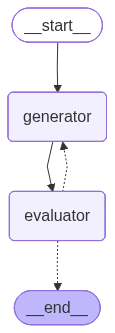

In [20]:
graph_builder = StateGraph(State)

graph_builder.add_node("generator", generator)
graph_builder.add_node(
    "evaluator",
    evaluator,
    destinations=(
        "generator",
        END,
    ),
)

graph_builder.add_edge(START, "generator")
graph_builder.add_edge("generator", "evaluator")


graph = graph_builder.compile()

graph

In [21]:
with open("fed_transcript.md", "r", encoding="utf-8") as file:
    document = file.read()


for chunk in graph.stream(
    {
        "document": document,
    }
):
    print(chunk, "\n")

{'generator': {'summary': 'The Federal Open Market Committee announced a 0.25‑percentage‑point cut to the federal‑funds rate and continued balance‑sheet reduction, citing a shift in risks toward weaker employment and still‑elevated inflation. Recent data show growth slowing to about 1.5\u202f% annualized, consumer spending weakening, housing activity remaining soft, while business investment is picking up; the unemployment rate has nudged up to 4.3\u202f% and payroll gains have fallen to roughly 29\u202f000 jobs per month. Inflation has moderated but remains above the Fed’s 2\u202f% target, with overall prices up 2.7\u202f% YoY and core inflation near 2.9\u202f%, partly driven by higher goods prices and modest tariff effects. The Committee emphasized its commitment to the dual mandate of maximum employment and price stability, noting upside risks to inflation and downside risks to jobs, and said future policy will be data‑dependent. Chairman Powell reiterated the Fed’s independence, th